#Майнор ИАД. Домашнее задание 3. YOLO.

В этом задании вы напишете и обучите свой собственный YOLO детектор. Нужно будет разобраться со статьей: понять какого формата должна быть обучающая пара (x, y), как перевести лосс из математической формулы в питоновский код - ну и конечно понять и реализовать саму архитектуру модели.

Выборка на котрой мы будем обучать модель состоит из разнообразных фотографий яблок, бананов и апельсинов. Данные скачиваем [отсюда](https://drive.google.com/file/d/1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3/view?usp=sharing).

Баллы за ДЗ распределены следующим образом: 
- Выборка для YoloV1 - 2 балла
- YOLO модель - 2 балла
- YOLO Loss - 3 балла
- Вспомогательные функции - 2 балла
- Обучение и расчет метрик - 2 балла

Для построения и обучения можно использовать как pytorch, так и pytorch-lightning.

Да-да, баллов в сумме получается 11.

Ссылки на источники:
* [раз](https://github.com/motokimura/yolo_v1_pytorch)
* [два](https://jonathan-hui.medium.com/real-time-object-detection-with-yolo-yolov2-28b1b93e2088)
* [три](https://www.maskaravivek.com/post/yolov1/)

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pytorch_lightning torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install xmltodict pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Скачаем данные

In [4]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q data.zip
!rm data.zip
!ls -l

replace __MACOSX/._data? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
total 20
drwx------ 4 root root 4096 Nov 26 08:32 data
drwxr-xr-x 5 root root 4096 Dec 19 15:39 lightning_logs
drwxr-xr-x 3 root root 4096 Dec 19 15:27 __MACOSX
drwxr-xr-x 1 root root 4096 Dec 16 00:01 sample_data
drwxr-xr-x 5 root root 4096 Dec 19 15:39 wandb


Посмотрим как выглядит один из файлов разметки

In [5]:
!cat data/train/apple_3.xml

<annotation>
	<folder>train</folder>
	<filename>apple_3.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_3.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1000</width>
		<height>708</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>584</xmin>
			<ymin>438</ymin>
			<xmax>867</xmax>
			<ymax>708</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>492</xmin>
			<ymin>141</ymin>
			<xmax>740</xmax>
			<ymax>394</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>176</xmin>
			<ymin>199</ymin>
			<xmax>490</xmax>
			<ymax>466</ymax>
		</bndbox>
	</object>
	<obj

## Релизуйте выборку для YoloV1 - 2 балла

In [6]:
import os
import cv2
import json
import glob
import tqdm
import xmltodict

from IPython.core.display import struct

from typing import List

import pandas as pd
import numpy as np

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torch.autograd import Variable

import pytorch_lightning as pl

import albumentations as A
import albumentations.pytorch

from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import auc

In [7]:
import wandb

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: whatkatiedid. Use `wandb login --relogin` to force relogin


True

Так как в этом домашнем задании использовать аугментации для обучения __обязательно__ - советуем воспользоваться библиотекой albumentations.

Она  особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Для знакомства с этим механизмом советуем следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). 

Вы все еще можете избрать путь torchvision.transforms, вам потребуется знакомый нам метод `__getitem__`, однако вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную

__Обратите внимание__ на то, что в статье коробки предсказаний параметризуются через: _(x_center, y_center, width, height)_ (причем эти значения _относительные_), а в наших файлах - это _(x_min, y_min, x_max, y_max)_

Также, помните что модель должна предсказывать как прямоугольник с обьектом, так и вероятности каждого класса!

In [8]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}

class FruitDataset(Dataset):
    def __init__(self, data_dir, grid_size=7, num_bboxes=2, num_classes=len(class2tag), transforms=None):

        self.S = grid_size
        self.B = num_bboxes
        self.C = num_classes

        self.image_paths = sorted(glob.glob(os.path.join(data_dir, "*.jpg")))
        self.box_paths = sorted(glob.glob(os.path.join(data_dir, "*.xml")))

        assert len(self.image_paths) == len(self.box_paths)

        self.transforms = transforms

    def __convert_to_yolo_box_params(self, box_coordinates: List[int], im_w, im_h):
        """
        Перейти от [xmin, ymin, xmax, ymax] к [x_center, y_center, width, height].
      
        Обратите внимание, что параметры [x_center, y_center, width, height] - это
        относительные значение в отрезке [0, 1]

        :param: box_coordinates - координаты коробки в формате [xmin, ymin, xmax, ymax]
        :param: im_w - ширина исходного изображения
        :param: im_h - высота исходного изображения

        :return: координаты коробки в формате [x_center, y_center, width, height]
        """
        ans = []

        ans.append((box_coordinates[0] + box_coordinates[2]) / 2 / im_w)  # x_center
        ans.append((box_coordinates[1] + box_coordinates[3]) / 2 / im_h)  # y_center
      
        ans.append((box_coordinates[2] - box_coordinates[0]) / im_w)  # width
        ans.append((box_coordinates[3] - box_coordinates[1]) / im_h)  # height
        return torch.Tensor(ans)


    def __get_boxes_from_xml(self, xml_filename: str, im_w, im_h):
        """
        Метод, который считает и распарсит (с помощью xmltodict) переданный xml
        файл и вернет координаты прямоугольников обьектов на соответсвующей фотографии
        и название класса обьекта в каждом прямоугольнике

        Обратите внимание, что обьектов может быть как несколько, так и один единственный
        """
        boxes = []
        class_labels = []
        with open(xml_filename) as xml_file:
            xml_text = xml_file.read()
        xml_dict = xmltodict.parse(xml_text)
        objects_img = xml_dict['annotation']['object']
        if type(objects_img) is list:
            for obj in objects_img:
                boxes.append(self.__convert_to_yolo_box_params(list(map(int, obj['bndbox'].values())), im_w, im_h))
                class_labels.append(class2tag[obj['name']])
        else:
            boxes.append(self.__convert_to_yolo_box_params(list(map(int, objects_img['bndbox'].values())), im_w, im_h))
            class_labels.append(class2tag[objects_img['name']])
        return boxes, class_labels
    
    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        im_h, im_w, _ = image.shape
        boxes, class_labels = self.__get_boxes_from_xml(self.box_paths[idx], im_w, im_h)
        
        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, class_labels=class_labels)
            image, boxes = transformed['image'], transformed['bboxes']
            class_labels = transformed['class_labels']
        if len(boxes) > 0:
            boxes = torch.tensor(boxes, dtype=torch.float)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float)
        
        S, B, C = self.S, self.B, self.C
        N = 5 * B + C
        target_tensor = torch.zeros(S, S, N, dtype=torch.float)
        
        for k in range(len(boxes)):
            box = boxes[k]
            for i in range(7):
                for j in range(7):
                    if (i / 7) <= box[0] and box[0] <= ((i + 1) / 7):
                        if (j / 7) <= box[1] and box[1] <= ((j + 1) / 7):
                            if target_tensor[i][j][0] == 0:
                                target_tensor[i][j][0] = (box[0] - (i / 7)) * 7
                                target_tensor[i][j][1] = (box[1] - (j / 7)) * 7
                                target_tensor[i][j][2] = box[2]
                                target_tensor[i][j][3] = box[3]
                                target_tensor[i][j][4] = 1
                            else:
                                target_tensor[i][j][5] = (box[0] - (i / 7)) * 7
                                target_tensor[i][j][6] = (box[1] - (j / 7)) * 7
                                target_tensor[i][j][7] = box[2]
                                target_tensor[i][j][8] = box[3]
                                target_tensor[i][j][9] = 1
                            target_tensor[i][j][9 + class_labels[k]] = 1

        image = image.to(torch.float)
        target_tensor = target_tensor.to(torch.float)
        return image, target_tensor

    def __len__(self):
        return len(self.image_paths)

In [9]:
IMAGE_SIZE = 448
train_transform = A.Compose([A.Resize(width=IMAGE_SIZE, height=IMAGE_SIZE),
                             A.HorizontalFlip(p=0.5),
                             A.VerticalFlip(p=0.5),
                             A.pytorch.transforms.ToTensorV2()],
                             bbox_params=A.BboxParams(format='yolo',
                                                      label_fields=['class_labels']))
test_transform = A.Compose([A.Resize(width=IMAGE_SIZE, height=IMAGE_SIZE),
                            A.HorizontalFlip(p=0.5),
                            A.VerticalFlip(p=0.5),
                            A.pytorch.transforms.ToTensorV2()],
                             bbox_params=A.BboxParams(format='yolo',
                                                     label_fields=['class_labels']))

In [10]:
train_dataset = FruitDataset(
    transforms=train_transform,
    data_dir="/content/data/train"
    )

val_dataset = FruitDataset(
    transforms=test_transform, 
    data_dir="/content/data/test"
    )

# Немного проверок, чтобы убедиться в правильности направления решения
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[0][0], torch.Tensor)
print("Тесты успешно пройдены")

Тесты успешно пройдены


In [11]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size= 4,
    shuffle=True)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4, 
    shuffle=False
    )

Теперь начинается основная часть домашнего задания: обучите модель YOLO для object detection на __обучающем__ датасете. 

 - Создайте модель и функцию ошибки YoloV1 прочитав [оригинальную статью](https://paperswithcode.com/paper/you-only-look-once-unified-real-time-object)
 - Напишите функцию обучения модели
 - Используйте аугментации

## Реализуйте Модель - 2 балла

Копировать точное количество слоев и параметры сверток необязательно. Главное - чтобы модель работала по принципу, описанному в статье и делала предсказание в представленном формате.


В качестве подсказки напомним, что выходом модели __для каждого обьекта__ должен быть тензор размера
__S * S * (B * 5 + С)__, где все параметры имеют такое же значение, как и в статье: 

- S - количество ячеек на которое разбивается изображение по вертикали/горизонтали
- В - количество предсказываемых прямоугольников в каждой ячейке
- 5 - количество параметров для определения каждого прямоугольника (x_center, y_center, width, height, confidence)
- С - количество классов (apple, banana, orange)

Таким образом, мы для каждого окна размера __S x S__ предсказываем __В__ коробо и один класс

In [12]:
class CNNBlock(nn.Module):  # можно поменять на Lightning
    def __init__(self, in_channels, out_channels, is_max_pool:bool=False, **kwargs):
        
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels, dtype=torch.float)  # в статье еще не знали про батчнорм, но мы то из будущего ...
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.is_maxpool = is_max_pool  # не после каждой свертки нужно делать maxpool
        self.maxpool = nn.MaxPool2d(2, stride=2)
        
    def forward(self, x):
        x = self.leakyrelu(self.batchnorm(self.conv(x)))

        if self.is_maxpool:
            x = self.maxpool(x)

        return x
    
class YOLO(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super(YOLO, self).__init__()

        self.S = S
        self.B = B
        self.C = C

        out_final = S * S * (B*5+C)
        self.cnn1 = CNNBlock(in_channels=3, out_channels=64, kernel_size=(7,7), is_max_pool=True, padding=3, stride=2, dtype=torch.float)
        self.cnn2 = CNNBlock(in_channels=64, out_channels=192, kernel_size=(3,3), is_max_pool=True, padding=1, dtype=torch.float)
        self.cnn3 = nn.Sequential(
            CNNBlock(in_channels=192, out_channels=128, kernel_size=(1,1), dtype=torch.float),
            CNNBlock(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1, dtype=torch.float),
            CNNBlock(in_channels=256, out_channels=256, kernel_size=(1,1), dtype=torch.float),
            CNNBlock(in_channels=256, out_channels=512, kernel_size=(3,3), padding=1, is_max_pool=True, dtype=torch.float)
        )
        self.cnn4 = nn.Sequential(
            CNNBlock(in_channels=512, out_channels=256, kernel_size=(1,1), dtype=torch.float),
            CNNBlock(in_channels=256, out_channels=512, kernel_size=(3,3), padding=1, dtype=torch.float),
            CNNBlock(in_channels=512, out_channels=256, kernel_size=(1,1), dtype=torch.float),
            CNNBlock(in_channels=256, out_channels=512, kernel_size=(3,3), padding=1, dtype=torch.float),
            CNNBlock(in_channels=512, out_channels=256, kernel_size=(1,1), dtype=torch.float),
            CNNBlock(in_channels=256, out_channels=512, kernel_size=(3,3), padding=1, dtype=torch.float),
            CNNBlock(in_channels=512, out_channels=256, kernel_size=(1,1), dtype=torch.float),
            CNNBlock(in_channels=256, out_channels=512, kernel_size=(3,3), padding=1, dtype=torch.float),
            CNNBlock(in_channels=512, out_channels=512, kernel_size=(1,1), dtype=torch.float),
            CNNBlock(in_channels=512, out_channels=1024, kernel_size=(3,3), padding=1, is_max_pool=True, dtype=torch.float)
        )
        self.cnn5 = nn.Sequential(
            CNNBlock(in_channels=1024, out_channels=512, kernel_size=(1,1), dtype=torch.float),
            CNNBlock(in_channels=512, out_channels=1024, kernel_size=(3,3), padding=1, dtype=torch.float),
            CNNBlock(in_channels=1024, out_channels=512, kernel_size=(1,1), dtype=torch.float),
            CNNBlock(in_channels=512, out_channels=1024, kernel_size=(3,3), padding=1, dtype=torch.float),
            CNNBlock(in_channels=1024, out_channels=1024, kernel_size=(3,3), padding=1, dtype=torch.float),
            CNNBlock(in_channels=1024, out_channels=1024, kernel_size=(3,3), padding=1, stride=2, dtype=torch.float),
        )
        self.cnn6 = nn.Sequential(
            CNNBlock(in_channels=1024, out_channels=1024, kernel_size=(3,3), padding=1, dtype=torch.float),
            CNNBlock(in_channels=1024, out_channels=1024, kernel_size=(3,3), padding=1, dtype=torch.float)
        )
        self.fl = nn.Flatten()
        self.lin = nn.Sequential(
            nn.Linear(in_features= self.S * self.S * 1024, out_features=2048, dtype=torch.float),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=2048, out_features=out_final, dtype=torch.float)
        )


    def forward(self, x):
        S, B, C = self.S, self.B, self.C
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.cnn4(x)
        x = self.cnn5(x)
        x = self.cnn6(x)
        x = self.fl(x)
        x = self.lin(x)
        x = x.view(-1, S, S, 5 * B + C)
        return x

In [13]:
# Убедитесь на одном изображении, что предсказания вашей модели имеют верное количество значений

temp_model = YOLO()
temp_model.eval()
expected_output_shape = temp_model.S * temp_model.S * (5 * temp_model.B + temp_model.C)

# print(temp_model(testing_image))
testing_image = train_dataset[0][0]
testing_image = testing_image[None, :]


assert temp_model(testing_image).reshape(-1).shape[0] == expected_output_shape

## Реализуйте YoloLoss - 3 балла

Теперь определим функцию для рассчета Intersection Over Union по 4 углам двух прямоугольников

In [14]:
def intersection_over_union(predicted_bboxes, gt_bboxes) -> float:
    """
    Intersection Over Union для двух прямоугольников

    :param: predicted_bboxes - (Tensor) of [x_min, y_min, x_max, y_max]
    :param: gt_bboxes - (Tensor) of [x_min, y_min, x_max, y_max]
    
    :return: Intersection Over Union
    """

    N = predicted_bboxes.size(0)
    M = gt_bboxes.size(0)


    lt = torch.max(
            predicted_bboxes[:, :2].unsqueeze(1).expand(N, M, 2),
            gt_bboxes[:, :2].unsqueeze(0).expand(N, M, 2)
    )
    rb = torch.min(
            predicted_bboxes[:, 2:].unsqueeze(1).expand(N, M, 2),
            gt_bboxes[:, 2:].unsqueeze(0).expand(N, M, 2)
    )
    wh = rb - lt
    wh[wh < 0] = 0
    intersection_area = wh[:, :, 0] * wh[:, :, 1]

    area_dt = (predicted_bboxes[:, 2] - predicted_bboxes[:, 0]) * (predicted_bboxes[:, 3] - predicted_bboxes[:, 1])
    area_gt = (gt_bboxes[:, 2] - gt_bboxes[:, 0]) * (gt_bboxes[:, 3] - gt_bboxes[:, 1])
    area_dt = area_dt.unsqueeze(1).expand_as(intersection_area)
    area_gt = area_gt.unsqueeze(0).expand_as(intersection_area)

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

In [15]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super().__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        S, B, C = self.S, self.B, self.C
        N = 5 * B + C
        batch_size = predictions.size(0)

        coord_mask = target[:, :, :, 4] > 0
        noobj_mask = target[:, :, :, 4] == 0
        coord_mask = coord_mask.unsqueeze(-1).expand_as(target)
        noobj_mask = noobj_mask.unsqueeze(-1).expand_as(target)

        coord_pred = predictions[coord_mask].view(-1, N) 

        class_pred = coord_pred[:, 5*B:]

        coord_target = target[coord_mask].view(-1, N)

        class_target = coord_target[:, 5*B:]

        loss_class = self.mse(class_pred, class_target)
        
        noobj_pred = predictions[noobj_mask].view(-1, N)
        noobj_target = target[noobj_mask].view(-1, N)

        noobj_conf_mask = torch.cuda.BoolTensor(noobj_pred.size()).fill_(0)
        for b in range(B):
            noobj_conf_mask[:, 4 + b*5] = 1
        noobj_pred_conf = noobj_pred[noobj_conf_mask]
        noobj_target_conf = noobj_target[noobj_conf_mask]
        loss_noobj = self.mse(noobj_pred_conf, noobj_target_conf)
        
        bbox_target = coord_target[:, :5*B].contiguous().view(-1, 5)
        bbox_pred = coord_pred[:, :5*B].contiguous().view(-1, 5)

        coord_response_mask = torch.cuda.BoolTensor(bbox_target.size()).fill_(0)
        coord_not_response_mask = torch.cuda.BoolTensor(bbox_target.size()).fill_(1)
        bbox_target_iou = torch.zeros(bbox_target.size()).cuda()

        for i in range(0, bbox_target.size(0), B):
            pred = bbox_pred[i:i+B]
            pred_xyxy = Variable(torch.FloatTensor(pred.size()))

            pred_xyxy[:,  :2] = pred[:, :2] / float(S) - 0.5 * pred[:, 2:4]
            pred_xyxy[:, 2:4] = pred[:, :2] / float(S) + 0.5 * pred[:, 2:4]

            targ = bbox_target[i]
            targ = bbox_target[i].view(-1, 5)
            target_xyxy = Variable(torch.FloatTensor(targ.size())) 

            target_xyxy[:,  :2] = targ[:, :2] / float(S) - 0.5 * targ[:, 2:4]
            target_xyxy[:, 2:4] = targ[:, :2] / float(S) + 0.5 * targ[:, 2:4]

            iou = intersection_over_union(pred_xyxy[:, :4], target_xyxy[:, :4])
            max_iou, max_index = iou.max(0)
            max_index = max_index.data.cuda()

            coord_response_mask[i + max_index] = 1
            coord_not_response_mask[i + max_index] = 0

            bbox_target_iou[i + max_index, torch.LongTensor([4]).cuda()] = (max_iou).data.cuda()
        bbox_target_iou = Variable(bbox_target_iou).cuda()
        bbox_pred_response = bbox_pred[coord_response_mask].view(-1, 5)
        bbox_target_response = bbox_target[coord_response_mask].view(-1, 5)
        target_iou = bbox_target_iou[coord_response_mask].view(-1, 5)

        loss_xy = self.mse(bbox_pred_response[:, :2], bbox_target_response[:, :2])
        loss_wh = self.mse(torch.sqrt(abs(bbox_pred_response[:, 2:4])), torch.sqrt(abs(bbox_target_response[:, 2:4])))
        

        loss_obj = self.mse(bbox_pred_response[:, 4], target_iou[:, 4])

        
        loss = self.lambda_coord * (loss_xy + loss_wh) + loss_obj + self.lambda_noobj * loss_noobj + loss_class
        
        loss = loss / float(batch_size)
        return loss

## Реализуйте дополнительные функции из статьи - 2 балла

In [16]:
def decode(pred_tensor):
        """ Decode tensor into box coordinates, class labels, and probs_detected.
        Args:
            pred_tensor: (tensor) tensor to decode sized [S, S, 5 x B + C], 5=(x, y, w, h, conf)
        Returns:
            boxes: (tensor) [[x1, y1, x2, y2]_obj1, ...]. Normalized from 0.0 to 1.0 w.r.t. image width/height, sized [n_boxes, 4].
            labels: (tensor) class labels for each detected boxe, sized [n_boxes,].
            confidences: (tensor) objectness confidences for each detected box, sized [n_boxes,].
            class_scores: (tensor) scores for most likely class for each detected box, sized [n_boxes,].
        """
        S = 7
        B = 2
        C = 3
        boxes, labels, confidences, class_scores = [], [], [], []

        cell_size = 1.0 / float(S)

        conf = pred_tensor[:, :, 4].unsqueeze(2)
        for b in range(1, B):
            conf = torch.cat((conf, pred_tensor[:, :, 5*b + 4].unsqueeze(2)), 2)
        conf_mask = conf > .5
        for i in range(S):
            for j in range(S):
                class_score, class_label = torch.max(pred_tensor[j, i, 5*B:], 0)
                for b in range(B):
                    conf = pred_tensor[j, i, 5*b + 4]
                    prob = conf * class_score
                    
                    if float(prob) < .5:
                        continue
                    box = pred_tensor[j, i, 5*b : 5*b + 4]
                    x0y0_normalized = torch.FloatTensor([i, j]) * cell_size
                    xy_normalized = box[:2] * cell_size + x0y0_normalized
                    wh_normalized = box[2:]
                    box_xyxy = torch.FloatTensor(4)
                    box_xyxy[:2] = xy_normalized - 0.5 * wh_normalized
                    box_xyxy[2:] = xy_normalized + 0.5 * wh_normalized

                    boxes.append(box_xyxy)
                    labels.append(class_label)
                    confidences.append(conf)
                    class_scores.append(class_score)
        if len(boxes) > 0:
            boxes = torch.stack(boxes, 0)
            labels = torch.stack(labels, 0)
            confidences = torch.stack(confidences, 0)
            class_scores = torch.stack(class_scores, 0)
        else:
            boxes = torch.FloatTensor(0, 4)
            labels = torch.LongTensor(0)
            confidences = torch.FloatTensor(0)
            class_scores = torch.FloatTensor(0)

        return boxes, labels, confidences, class_scores

In [17]:
def non_max_suppression(boxes, scores, iou_threshold=.5):
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    areas = (x2 - x1) * (y2 - y1)

    _, ids_sorted = scores.sort(0, descending=True)
    ids = []
    while ids_sorted.numel() > 0:
        i = ids_sorted.item() if (ids_sorted.numel() == 1) else ids_sorted[0]
        ids.append(i)

        if ids_sorted.numel() == 1:
            break

        inter_x1 = x1[ids_sorted[1:]].clamp(min=x1[i])
        inter_y1 = y1[ids_sorted[1:]].clamp(min=y1[i])
        inter_x2 = x2[ids_sorted[1:]].clamp(max=x2[i])
        inter_y2 = y2[ids_sorted[1:]].clamp(max=y2[i])
        inter_w = (inter_x2 - inter_x1).clamp(min=0)
        inter_h = (inter_y2 - inter_y1).clamp(min=0)

        inters = inter_w * inter_h
        unions = areas[i] + areas[ids_sorted[1:]] - inters
        ious = inters / unions

        ids_keep = (ious <= iou_threshold).nonzero().squeeze()
        if ids_keep.numel() == 0:
            break
        ids_sorted = ids_sorted[ids_keep+1]

    return torch.LongTensor(ids)

In [18]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5):
    ## YOUR CODE
    pass



In [19]:
def get_bound_boxes(pred_tensor, iou_threshold=.5, threshold=.4):
    pred_tensor = pred_tensor.squeeze(0)
    boxes_normalized_all, class_labels_all, confidences_all, class_scores_all = decode(pred_tensor)
    if boxes_normalized_all.size(0) == 0:
        return [], [], []
    boxes_normalized, class_labels, probs = [], [], []
    h = IMAGE_SIZE
    w = IMAGE_SIZE
    class_name_list = list(class2tag.keys())

    for class_label in range(len(class_name_list)):
        mask = (class_labels_all == class_label)
        if torch.sum(mask) == 0:
            continue

        boxes_normalized_masked = boxes_normalized_all[mask]
        class_labels_maked = class_labels_all[mask]
        confidences_masked = confidences_all[mask]
        class_scores_masked = class_scores_all[mask]

        ids = non_max_suppression(boxes_normalized_masked, confidences_masked)

        boxes_normalized.append(boxes_normalized_masked[ids])
        class_labels.append(class_labels_maked[ids])
        probs.append(confidences_masked[ids] * class_scores_masked[ids])

    boxes_normalized = torch.cat(boxes_normalized, 0)
    class_labels = torch.cat(class_labels, 0)
    probs = torch.cat(probs, 0)

    boxes_detected, class_names_detected, probs_detected = [], [], []
    for b in range(boxes_normalized.size(0)):
        box_normalized = boxes_normalized[b]
        class_label = class_labels[b]
        prob = probs[b]

        x1, x2 = w * box_normalized[0], w * box_normalized[2]
        y1, y2 = h * box_normalized[1], h * box_normalized[3]
        boxes_detected.append(((x1, y1), (x2, y2)))

        class_label = int(class_label)
        class_name = class_name_list[class_label]
        class_names_detected.append(class_name)

        prob = float(prob)
        probs_detected.append(prob)
    return boxes_detected, class_names_detected, probs_detected

## Обучите модель и посчитайте метрики для задачи детекции - 2 балла 

Несмотря на то, что в этом блоке ничего сильно нового для вас не ожидается и за него формально дается лишь два балла - провести обучение очень важно для понимания того, насколько правильно реализована ваша модель и лосс.

В процессе обучения будет видно все ли размерности совпадают, падает ли лосс и растут ли метрики целевой задачи, поэтому на практике этот пункт гораздо оказывается гораздо важнее.

In [20]:
class YOLOLearner(pl.LightningModule):
    def __init__(self) -> None:
        super().__init__()

        self.model = YOLO()
        self.loss = YoloLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.save_hyperparameters()

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.model(images)
        loss = self.loss(preds, target)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.model(images)
        loss = self.loss(preds, target)
        self.log('val_loss', loss, prog_bar=True)

In [21]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer

In [31]:
wandb_logger = WandbLogger(log_model='all')
checkpoint_callback = ModelCheckpoint(monitor='train_loss', mode='max')

In [32]:
n_epochs = 8

yolo_learner = YOLOLearner()

device = "gpu" if torch.cuda.is_available() else "cpu"
trainer = pl.Trainer(logger=wandb_logger, callbacks=[checkpoint_callback], max_epochs=n_epochs,
                 accelerator=device)


trainer.fit(yolo_learner, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params
-----------------------------------
0 | model | YOLO     | 164 M 
1 | loss  | YoloLoss | 0     
-----------------------------------
164 M     Trainable params
0         Non-trainable params
164 M     Total params
657.000   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.


In [33]:
wandb.finish()

epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_loss,▄▄▁█▃▂▂▁▁
trainer/global_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▇▇██
val_loss,█▁▁▁▁▁▁▁
epoch,7
train_loss,60.53193
trainer/global_step,479
val_loss,167.55276


[Ссылка](https://wandb.ai/whatkatiedid/lightning_logs?workspace=user-whatkatiedid) на Wandb

## Посчитайте метрики задачи детекции на валидационной выборке

Попробуйте понять насколько хороши ваши показатели. Если числа кажутся подозрительно низкими - возможно вам стоит перепроверить ваше решение. 

## Визуализируйте предсказанные bounding box'ы для любых пяти картинок из __валидационного__ датасета.

In [34]:
import random
from PIL import ImageDraw

In [35]:
def show_images(dataset) -> None:
    n = 5
    f, axarr = plt.subplots(3,2, figsize=(20, 20))
    for k in range(n):
        rand = random.randint(0, len(dataset) - 1)
        image, targets = dataset[rand]
        train_image = image[None, :]

        preds = yolo_learner(train_image)
        preds = torch.reshape(preds, (7, 7, 13))

        w = image.shape[1]
        h = image.shape[2]

        image_new = torchvision.transforms.ToPILImage()(image)
        draw = ImageDraw.Draw(image_new)
        for i in range(targets.shape[0]):
            for j in range(targets.shape[1]):
                if targets[i][j][4] != 0:
                    x_center = targets[i][j][0] / 7 * w + i * w / 7
                    xmin = x_center - targets[i][j][2] / 2 * w
                    xmax = x_center + targets[i][j][2] / 2 * w
                    y_center = targets[i][j][1] / 7 * h + j * h / 7
                    ymin = y_center - targets[i][j][3] / 2 * h
                    ymax = y_center + targets[i][j][3] / 2 * h
                    draw.rectangle([xmin, ymin, xmax, ymax])

                    x_center = preds[i][j][0] / 7 * w + i * w / 7
                    xmin = x_center - preds[i][j][2] / 2 * w
                    xmax = x_center + preds[i][j][2] / 2 * w
                    y_center = preds[i][j][1] / 7 * h + j * h / 7
                    ymin = y_center - preds[i][j][3] / 2 * h
                    ymax = y_center + preds[i][j][3] / 2 * h
                    draw.rectangle([xmin, ymin, xmax, ymax], outline='red')
        axarr[k // 2][k % 2].imshow(image_new, aspect='auto')
    axarr[2][1].remove()
    f.show()

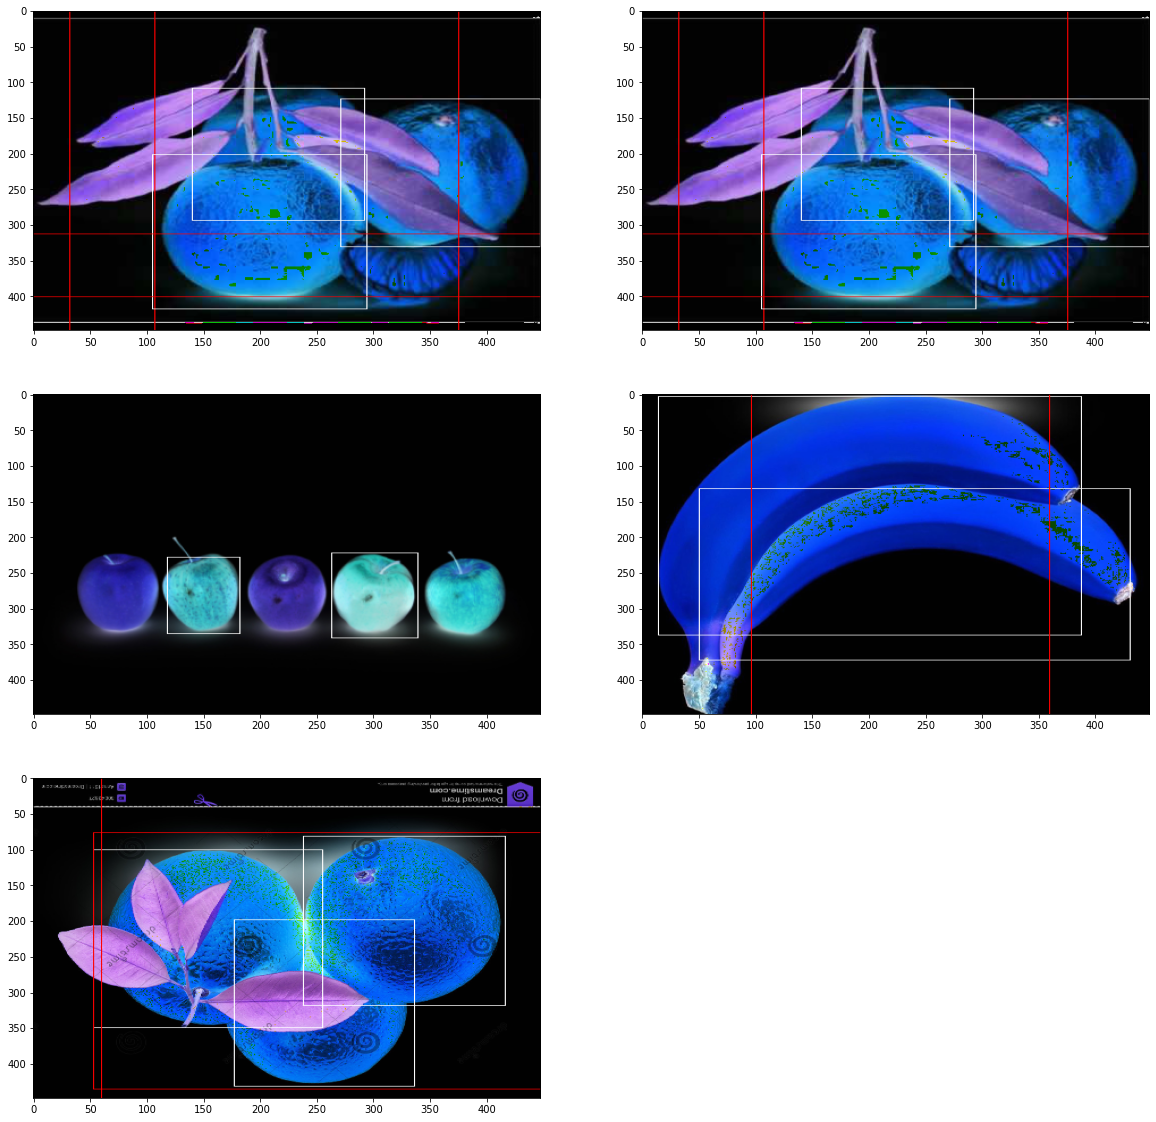

In [43]:
show_images(val_dataset)